# Data Challenge 2: Investigating a Drop in User Engagement

### Yammer:
Yammer is a social network for communicating with coworkers. Individuals share documents, updates, and ideas by posting them in groups, it’s like Slack. Yammer is free to use indefinitely, but companies must pay license fees if they want access to administrative controls, including integration with user management systems like ActiveDirectory.

## Problem
You show up to work Tuesday morning, September 2, 2014. The head of the Product team walks over to your desk and asks you what you think about the latest activity on the user engagement dashboards (yes this really happens). You fire them up, and something immediately jumps out:

<img src="Fig1.png" alt="drawing" width="500"/>


### Interactive Engagement Dashboard:

https://modeanalytics.com/modeanalytics/reports/cbb8c291ee96/runs/7925c979521e/viz/cfcdb6b78885


The above chart shows the number of engaged users each week. Yammer defines engagement as having made some type of server call by interacting with the product (shown in the data as events of type “engagement”). Any point in this chart can be interpreted as “the number of users who logged at least one engagement event during the week starting on that date.”


## Question:

The head of product says “Can you look into this and get me a summary by this afternoon?”  As she runs to a meeting.

## Hints:

- Make sure you really understand what the above chart shows, and what it means!

- Remember don’t start with the data, start with the hypothesis.  Maybe have an ordered set you can check.

- How do you order your hypothesis in descending importance?

- Remember, time is critical here, so think about how you’re spending your time!


## Digging in:

For this problem, you have four sources of data. The tables names and column definitions are listed below—click a table name to view information about that table. Note: this data is fake and was generated for the purpose of this case study. It is similar in structure to Yammer’s actual data, but for privacy and security reasons it is not real.


# Solution:

We start with different hypothesis and delve into some of them.

##  App is down or some features are broken
One of the main reasons for reduced engagement is often the fact that the app itself is down or some of its features are either broken or redesigned in a way that is not user-friendly.

### Sign-Up feature broken?
One of the features that if broken can reduce the engagement activity is user sign-up process. To check this we take a look at the time history of creating accounts and activating accounts by the users.

Importing the needed libraries and packages:

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateFormatter, AutoDateLocator, WeekdayLocator
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

Reading different csv files/tables:

In [13]:
users=pd.read_csv("yammer_users.csv")
emails=pd.read_csv("yammer_emails.csv")
events=pd.read_csv("yammer_events.csv")
periods=pd.read_csv("dimension_rollup_periods.csv")

- We create new columns and convert string date-time entries into timestamps
- also every sample (row), based on its timestamp is mapped to a time_id (by the function assign_time_id) which is the last day of the week that the timestamp belongs to.

In [128]:
users["created_at2"]=users["created_at"].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
users["created_time_id"]=users["created_at2"].map(lambda x: assign_time_id(x))
users.head()

,user_id,created_at,company_id,language,activated_at,state,created_at2,created_time_id
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active,2013-01-01 20:59:39,2013-01-08
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending,2013-01-01 13:07:46,2013-01-08
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending,2013-01-01 10:59:05,2013-01-08
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active,2013-01-01 18:40:36,2013-01-08
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01 14:37:51,2013-01-08


In [149]:
users["activated"]=users["activated_at"].notnull().astype("int")
users["created_day"]=users["created_at"].map(lambda x: datetime.datetime.strptime(x.split()[0], '%Y-%m-%d'))
users.head()

,user_id,created_at,company_id,language,activated_at,state,created_at2,created_time_id,created_day,activated
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active,2013-01-01 20:59:39,2013-01-08,2013-01-01,1
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending,2013-01-01 13:07:46,2013-01-08,2013-01-01,0
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending,2013-01-01 10:59:05,2013-01-08,2013-01-01,0
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active,2013-01-01 18:40:36,2013-01-08,2013-01-01,1
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active,2013-01-01 14:37:51,2013-01-08,2013-01-01,1


To test our hypothesis that sign-up feature is causing the issue, we plot the time history of number of user sign-ups (with and without account activation). We plot it for the last few months as well as the whole time range. The latter shows that in general the number of user sign-ups have been growing indicating that there is no issues with the sign-up feature of the app. To capture and understand the short time-scale decrease-increase pattern of the number of sign-ups, we take a look at a shorter time period (last few months); from this figure it becomes apparent that over the weekend the number of sign-ups decrease which intuitively makes sense. 

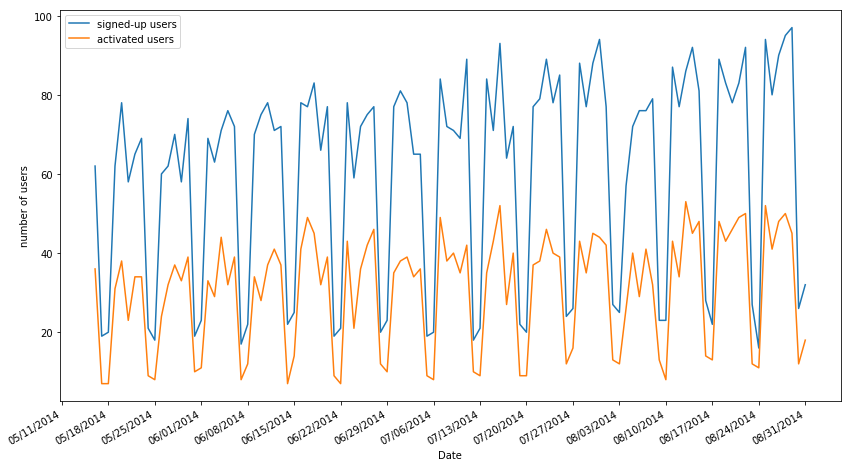

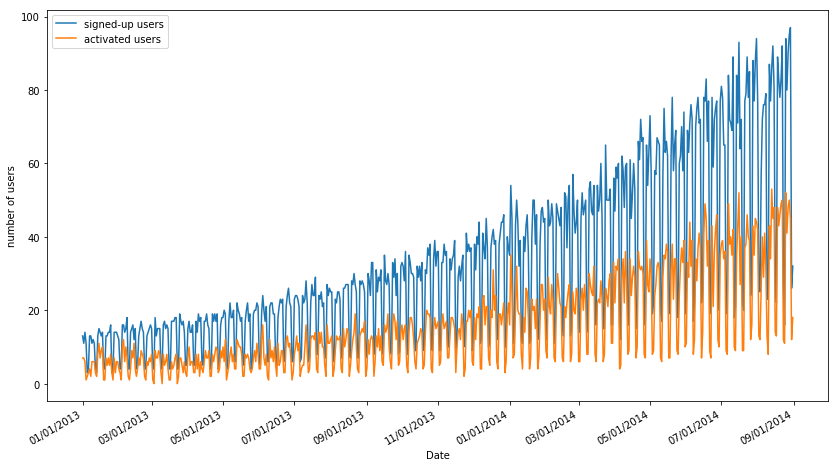

In [177]:
# plotting the time history of the number of sign-ups in the last few months

sunday = WeekdayLocator(SU)        # major ticks on the Sundays

created_users_list=users.groupby(["created_day"])["activated"].count()
activated_users_list=users.groupby(["created_day"])["activated"].sum()

fig, ax = plt.subplots(figsize=(14,8))
sns.lineplot(x=created_users_list.index[500:608], y=created_users_list.values[500:608], ax=ax, label="signed-up users")
sns.lineplot(x=activated_users_list.index[500:608], y=activated_users_list.values[500:608], ax=ax, label="activated users")

ax.xaxis.set_major_locator(sunday)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("number of users")
ax.legend()


# plotting the time history of the number of sign-ups in the whole time range

fig, ax = plt.subplots(figsize=(14,8))
sns.lineplot(x=created_users_list.index[0:608], y=created_users_list.values[0:608], ax=ax, label="signed-up users")
sns.lineplot(x=activated_users_list.index[0:608], y=activated_users_list.values[0:608], ax=ax, label="activated users")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("number of users")
ax.legend()


### a device-specific feature/component is broken?

Next we check to see if any device-specific feature could be a potential reason. There are 3 different devices types: computers, tablets, and phones. We break down engagement metrics based on device type. 

We check which columns have null values. 
The column of "activated_at" has null values and it corresponds to pending accounts

In [11]:
users.isnull().any()

user_id         False
created_at      False
company_id      False
language        False
activated_at     True
state           False
dtype: bool

In [196]:
emails["action"].unique()

array(['sent_weekly_digest', 'email_open', 'email_clickthrough',
       'sent_reengagement_email'], dtype=object)

In [87]:
emails["occurred_at2"]=emails["occurred_at"].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
emails["time_id"]=emails["occurred_at2"].map(lambda x: assign_time_id(x))
emails.head()

,user_id,occurred_at,action,user_type,occurred_at2,time_id
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0,2014-05-06 09:30:00,2014-05-13
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0,2014-05-13 09:30:00,2014-05-20
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0,2014-05-20 09:30:00,2014-05-27
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0,2014-05-27 09:30:00,2014-06-03
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0,2014-06-03 09:30:00,2014-06-10


In [79]:
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,occured_at2,time_id
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014-05-02 11:02:39,2014-05-06
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-05-02 11:02:53,2014-05-06
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0,2014-05-02 11:03:28,2014-05-06
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014-05-02 11:04:09,2014-05-06
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0,2014-05-02 11:03:16,2014-05-06


In [49]:
events["occured_at2"]=events["occurred_at"].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [178]:
events["device"].unique()

array(['dell inspiron notebook', 'iphone 5', 'iphone 4s',
       'windows surface', 'macbook air', 'iphone 5s', 'macbook pro',
       'kindle fire', 'ipad mini', 'nexus 7', 'nexus 5',
       'samsung galaxy s4', 'lenovo thinkpad', 'samsumg galaxy tablet',
       'acer aspire notebook', 'asus chromebook', 'htc one',
       'nokia lumia 635', 'samsung galaxy note', 'acer aspire desktop',
       'mac mini', 'hp pavilion desktop', 'dell inspiron desktop',
       'ipad air', 'amazon fire phone', 'nexus 10'], dtype=object)

In [184]:
phone_list=['iphone 5', 'iphone 4s', 'iphone 5s', 'samsung galaxy s4', 'htc one',
       'nokia lumia 635', 'amazon fire phone', 'samsung galaxy note']
tablet_list=['kindle fire', 'ipad mini', 'nexus 7', 'nexus 5', 'samsumg galaxy tablet', 'ipad air', 'nexus 10']
computer_list=['dell inspiron notebook', 'windows surface', 'macbook air', 'macbook pro', 'lenovo thinkpad',
               'acer aspire notebook', 'asus chromebook', 'acer aspire desktop', 'mac mini',
               'hp pavilion desktop', 'dell inspiron desktop']

len(phone_list)+len(tablet_list)+len(computer_list)==events["device"].nunique()


True

In [187]:
events["computer"]=events["device"].map(lambda x: 1 if x in computer_list else 0)
events["tablet"]=events["device"].map(lambda x: 1 if x in tablet_list else 0)
events["phone"]=events["device"].map(lambda x: 1 if x in phone_list else 0)

In [188]:
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,occured_at2,time_id,computer,tablet,phone
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014-05-02 11:02:39,2014-05-06,1,0,0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-05-02 11:02:53,2014-05-06,1,0,0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0,2014-05-02 11:03:28,2014-05-06,1,0,0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014-05-02 11:04:09,2014-05-06,1,0,0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0,2014-05-02 11:03:16,2014-05-06,1,0,0


We have two types of engagement and we consider only engagements other than "sign-up" flow.

In [190]:
events["event_type"].unique()

array(['engagement', 'signup_flow'], dtype=object)

Below we show the the number of engagement activity per device type. As seen in the figure there is a significant drop for computers and even more for phones. So there could be a problem in the mobile apps; maybe a broken feature or a recent change in the mobile app user-interface.

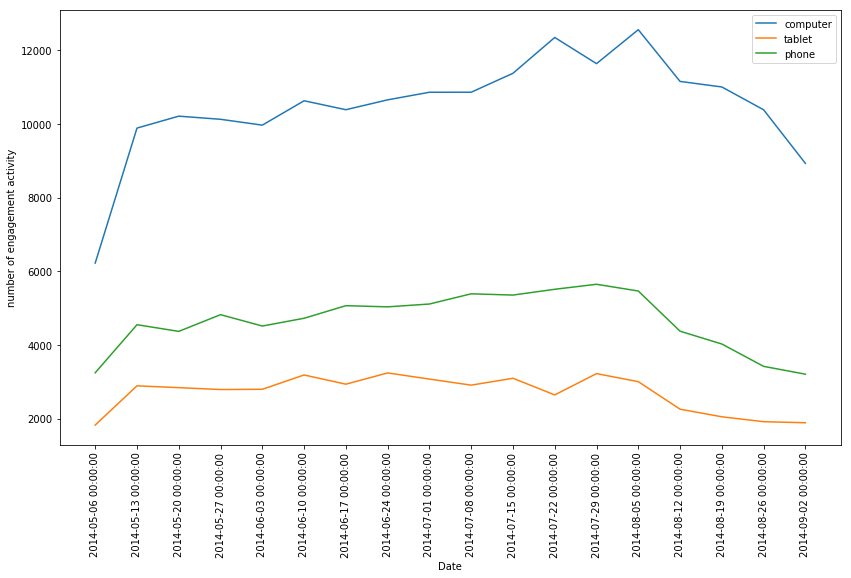

In [194]:
computer_events_list=events[events["event_type"]=='engagement'].groupby(["time_id"])["computer"].sum()
tablet_events_list=events[events["event_type"]=='engagement'].groupby(["time_id"])["tablet"].sum()
phone_events_list=events[events["event_type"]=='engagement'].groupby(["time_id"])["phone"].sum()

N = computer_events_list.shape[0]

fig, ax = plt.subplots(figsize=(14,8))
sns.lineplot(x=np.arange(N), y=computer_events_list.values, ax=ax, label="computer")
sns.lineplot(x=np.arange(N), y=tablet_events_list.values, ax=ax, label="tablet")
sns.lineplot(x=np.arange(N), y=phone_events_list.values, ax=ax, label="phone")

plt.xlabel("Date")
plt.ylabel("number of engagement activity")
plt.xticks(np.arange(N), active_users["time_id"])
plt.xticks(rotation='vertical')
ax.legend()


In [195]:
events["event_name"].unique()

array(['login', 'home_page', 'like_message', 'view_inbox', 'search_run',
       'send_message', 'search_autocomplete', 'search_click_result_10',
       'create_user', 'enter_email', 'enter_info', 'complete_signup',
       'search_click_result_7', 'search_click_result_8',
       'search_click_result_1', 'search_click_result_3',
       'search_click_result_2', 'search_click_result_5',
       'search_click_result_6', 'search_click_result_9',
       'search_click_result_4'], dtype=object)

### Issues with re-engagement / weekly emails?

Another issue could be that the email contents are such that they do not engage the users. To check this, we look into the email activities. Below we plot the time history of the number of email activities. Based on the figure, the only thing that drops is the email click-throughs; this suggests that there could be a problem with the weekly digest and re-engagement emails. 

In [197]:
emails.head()

,user_id,occurred_at,action,user_type,occurred_at2,time_id
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0,2014-05-06 09:30:00,2014-05-13
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0,2014-05-13 09:30:00,2014-05-20
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0,2014-05-20 09:30:00,2014-05-27
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0,2014-05-27 09:30:00,2014-06-03
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0,2014-06-03 09:30:00,2014-06-10


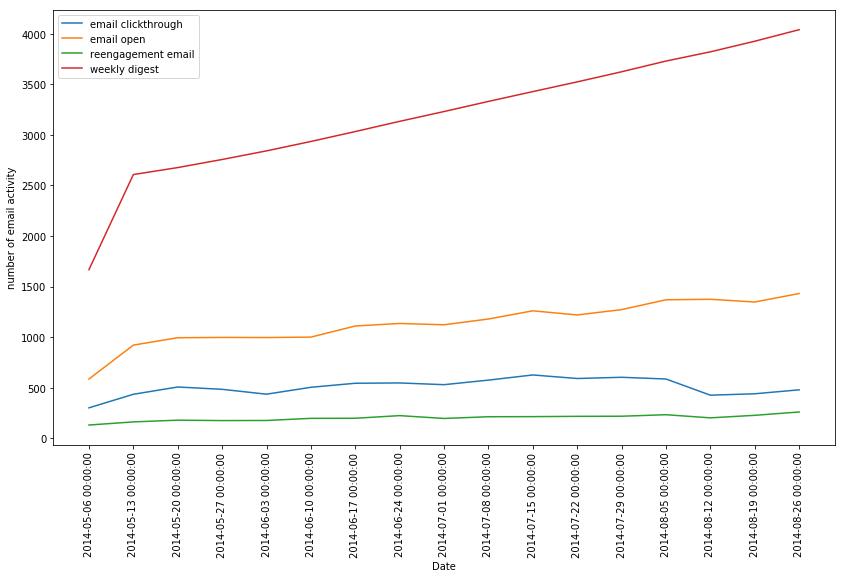

In [205]:
emails["action"].unique()
emails_conc=pd.concat([emails, pd.get_dummies(emails["action"])], axis=1) 

email_clickthrough_list = emails_conc.groupby(["time_id"])["email_clickthrough"].sum()
email_open_list = emails_conc.groupby(["time_id"])["email_open"].sum()
sent_reengagement_email_list = emails_conc.groupby(["time_id"])["sent_reengagement_email"].sum()
sent_weekly_digest_list = emails_conc.groupby(["time_id"])["sent_weekly_digest"].sum()

N = email_clickthrough_list.shape[0]

fig, ax = plt.subplots(figsize=(14,8))
sns.lineplot(x=np.arange(N-1), y=email_clickthrough_list.values[0:N-1], ax=ax, label="email clickthrough")
sns.lineplot(x=np.arange(N-1), y=email_open_list.values[0:N-1], ax=ax, label="email open")
sns.lineplot(x=np.arange(N-1), y=sent_reengagement_email_list.values[0:N-1], ax=ax, label="reengagement email")
sns.lineplot(x=np.arange(N-1), y=sent_weekly_digest_list.values[0:N-1], ax=ax, label="weekly digest")


plt.xlabel("Date")
plt.ylabel("number of email activity")
plt.xticks(np.arange(N-1), active_users["time_id"][0:N-1])
plt.xticks(rotation='vertical')
ax.legend()


In [74]:
periods.head()

,period_id,time_id,pst_start,pst_end,utc_start,utc_end
0,1.0,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-01 08:00:00,2013-01-02 08:00:00
1,1.0,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-03 00:00:00,2013-01-02 08:00:00,2013-01-03 08:00:00
2,1.0,2013-01-03 00:00:00,2013-01-03 00:00:00,2013-01-04 00:00:00,2013-01-03 08:00:00,2013-01-04 08:00:00
3,1.0,2013-01-04 00:00:00,2013-01-04 00:00:00,2013-01-05 00:00:00,2013-01-04 08:00:00,2013-01-05 08:00:00
4,1.0,2013-01-05 00:00:00,2013-01-05 00:00:00,2013-01-06 00:00:00,2013-01-05 08:00:00,2013-01-06 08:00:00


In [38]:
periods[periods["period_id"]==1007.0]

,period_id,time_id,pst_start,pst_end,utc_start,utc_end
1252,1007.0,2013-01-01 00:00:00,2012-12-25 00:00:00,2013-01-01 00:00:00,2012-12-25 08:00:00,2013-01-01 08:00:00
1253,1007.0,2013-01-02 00:00:00,2012-12-26 00:00:00,2013-01-02 00:00:00,2012-12-26 08:00:00,2013-01-02 08:00:00
1254,1007.0,2013-01-03 00:00:00,2012-12-27 00:00:00,2013-01-03 00:00:00,2012-12-27 08:00:00,2013-01-03 08:00:00
1255,1007.0,2013-01-04 00:00:00,2012-12-28 00:00:00,2013-01-04 00:00:00,2012-12-28 08:00:00,2013-01-04 08:00:00
1256,1007.0,2013-01-05 00:00:00,2012-12-29 00:00:00,2013-01-05 00:00:00,2012-12-29 08:00:00,2013-01-05 08:00:00
1257,1007.0,2013-01-06 00:00:00,2012-12-30 00:00:00,2013-01-06 00:00:00,2012-12-30 08:00:00,2013-01-06 08:00:00
1258,1007.0,2013-01-07 00:00:00,2012-12-31 00:00:00,2013-01-07 00:00:00,2012-12-31 08:00:00,2013-01-07 08:00:00
1259,1007.0,2013-01-08 00:00:00,2013-01-01 00:00:00,2013-01-08 00:00:00,2013-01-01 08:00:00,2013-01-08 08:00:00
1260,1007.0,2013-01-09 00:00:00,2013-01-02 00:00:00,2013-01-09 00:00:00,2013-01-02 08:00:00,2013-01-09 08:00:00
1261,1007.0,2013-01-10 00:00:00,2013-01-03 00:00:00,2013-01-10 00:00:00,2013-01-03 08:00:00,2013-01-10 08:00:00


In [37]:
periods[periods["period_id"]==1007.0].iloc[[0, -1]]

,period_id,time_id,pst_start,pst_end,utc_start,utc_end
1252,1007.0,2013-01-01 00:00:00,2012-12-25 00:00:00,2013-01-01 00:00:00,2012-12-25 08:00:00,2013-01-01 08:00:00
2346,1007.0,2015-12-31 00:00:00,2015-12-24 00:00:00,2015-12-31 00:00:00,2015-12-24 08:00:00,2015-12-31 08:00:00


In [75]:

periods7=periods[periods["period_id"]==1007.0].iloc[::7, :]
periods7["time_id2"]=periods7["time_id"].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
time_id=periods7["time_id2"]

In [84]:
def assign_time_id(timestamp):
    for t in time_id:
        if timestamp<=t:
            return t
        


In [77]:
events["time_id"]=events["occured_at2"].map(lambda x: assign_time_id(x))
# assign_time_id(events["occured_at2"][0])

In [106]:
weekly_active_users=events.groupby(["time_id"])["user_id"].nunique()
type(weekly_active_users)
weekly_active_users

time_id
2014-05-06     949
2014-05-13    1261
2014-05-20    1324
2014-05-27    1347
2014-06-03    1320
2014-06-10    1394
2014-06-17    1464
2014-06-24    1494
2014-07-01    1459
2014-07-08    1509
2014-07-15    1583
2014-07-22    1575
2014-07-29    1646
2014-08-05    1654
2014-08-12    1507
2014-08-19    1469
2014-08-26    1429
2014-09-02    1300
Name: user_id, dtype: int64

In [105]:
pd.Series.to_frame(weekly_active_users)
# weekly_active_users.reset_index(level=0, inplace=True)
type(weekly_active_users)

pandas.core.series.Series

In [109]:
active_users=pd.DataFrame({'time_id':weekly_active_users.index, 'n_active_users':weekly_active_users.values})

In [110]:
active_users

,time_id,n_active_users
0,2014-05-06,949
1,2014-05-13,1261
2,2014-05-20,1324
3,2014-05-27,1347
4,2014-06-03,1320
5,2014-06-10,1394
6,2014-06-17,1464
7,2014-06-24,1494
8,2014-07-01,1459
9,2014-07-08,1509


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

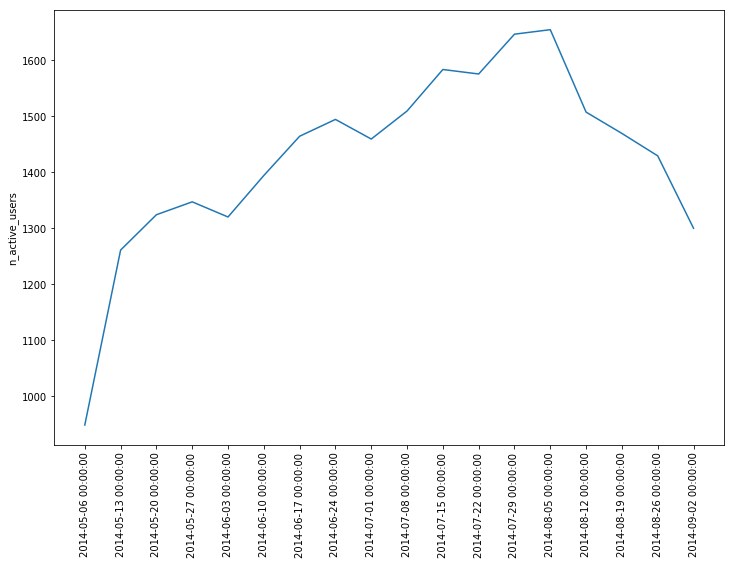

In [127]:
plt.figure(figsize=(12,8))

# xtick_locator = AutoDateLocator()
# xtick_formatter = AutoDateFormatter(xtick_locator)

# ax = plt.axes()
# ax.xaxis.set_major_locator(xtick_locator)
# ax.xaxis.set_major_formatter(xtick_formatter)

N = active_users.shape[0]
# x2 = np.arange(N)

# plt.plot(x2, y)

sns.lineplot(x=np.arange(N), y="n_active_users", data=active_users)
plt.xticks(np.arange(N), active_users["time_id"])
plt.xticks(rotation='vertical')

In [207]:
# users_grouped=users.groupby(["created_time_id"])["user_id"].nunique()
# sns.lineplot(x=users_grouped.index, y=users_grouped.values)
# plt.xticks(rotation='vertical')

## Conclusion:

So based on the analysis above, there are two major potential problems: mobile apps and weekly/re-engagement emails. 
Another potential problem could be that previous increase in the user engagemnt was due to bot-like user engagement. But based on the data, this hypothesis cannot be tested (we do not know if users in the data are bots or not).